In [5]:
import logging
logging.basicConfig(level=logging.INFO)

import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import numpy as np

import os

import matplotlib.pyplot as plt
import seaborn as sns
import tqdm


In [13]:
tqdm.tqdm_pandas(tqdm.tqdm_notebook())

In [9]:
%cd ..

/Users/isajosep/Code/Repos/Synthego


In [11]:
import sequence_parser

The provided CSV file ”synthesis data.csv” contains simulated data of 10 syntheses for several different custom sequences. This data is a smaller, simplified version of the data that the data science team at -- regularly collects. The data includes information about the quantity of material, overall quality, and time it took to process. These are the columns in the CSV:

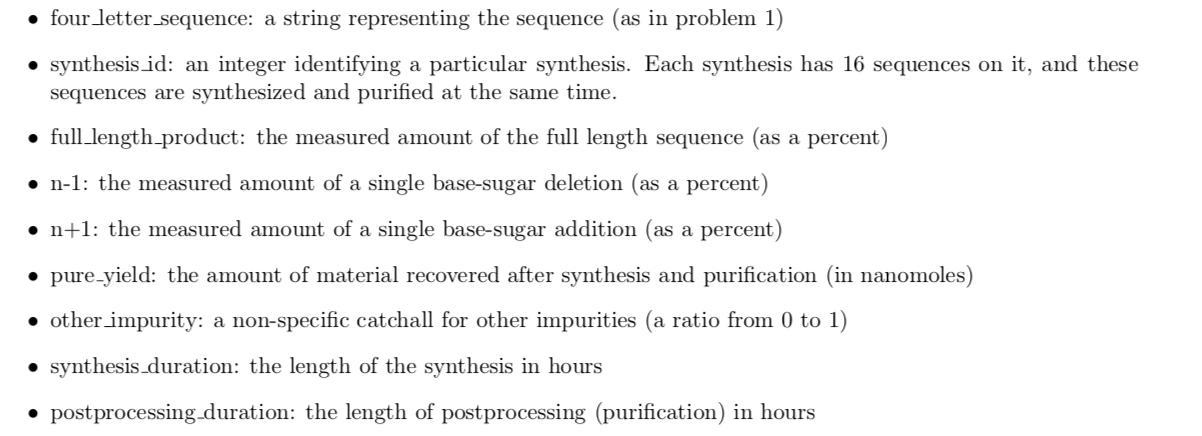

In [6]:
synth_data = pd.read_csv('/Users/isajosep/Data/Misc/synthesis_data.csv')

In [7]:
synth_data.sample(3)

,four_letter_sequence,synthesis_id,n-1,n+1,pure_yield,full_length_product,other_impurity,synthesis_duration,postprocessing_duration
57,-Cro-Gro-Aro-Aro-Uro-Aro-Uro-Gro-Aro-Uro-Cro-C...,4,8.589517,7.935955,2.397462,69.192073,0.014349,61.546239,60.160847
66,-Gro-Aro-Cro-Gro-Cro-Aro-Uro-Aro-Aro-Aro-Gro-A...,5,7.350241,9.868113,8.129809,72.076463,0.419470,56.237046,108.421597
71,-Aro-Cro-Aro-Aro-Aro-Gro-Uro-Cro-Aro-Cro-Aro-U...,5,4.886914,7.307557,4.952300,74.985244,0.582099,56.237046,108.421597


In [25]:
synth_data.shape

(160, 11)

# Annotate

## Length

In [18]:
synth_data['sequence_length'] = synth_data.progress_apply(lambda row: sequence_parser.sequence_str_to_len(row['four_letter_sequence']), axis=1)

In [23]:
synth_data.sequence_length.value_counts()

100    112
36      48
Name: sequence_length, dtype: int64

## Type

In [21]:
synth_data['product_type'] = synth_data.progress_apply(lambda row: sequence_parser.sequence_str_to_product_type(row['four_letter_sequence']), axis=1)

In [22]:
synth_data.product_type.value_counts()

mod RNA        64
vanilla RNA    48
chimera        48
Name: product_type, dtype: int64

# Pure Yield investigation

Basic idea: 

1. one-hot encode categorical variable `synthesis_id` and `product_type`, 
2. clean
3. standardize, 
4. then use a model to predict `synthesis_yield`, starting wtih simple ones. Assess based on train/test split.    
5. Interpret model 

## One-hot Encode

In [24]:
import sklearn.preprocessing

### `synthesis_id`

In [ ]:
sklearn.preprocessing.OneHotEncoder()

In [30]:
ohe = sklearn.preprocessing.OneHotEncoder(sparse=False)

In [33]:
ohe_fit = ohe.fit(synth_data.synthesis_id.values.reshape(-1,1))

In [53]:
one_hot_encoded_id = pd.DataFrame(ohe_fit.transform(synth_data.synthesis_id.values.reshape(-1,1)), index=synth_data.index, columns=["synthesis {}".format(i) for i in ohe_fit.active_features_])

In [55]:
synth_data_enc = synth_data.drop('synthesis_id', axis=1).join(one_hot_encoded_id)

In [56]:
synth_data_enc.sample(3)

,four_letter_sequence,n-1,n+1,pure_yield,full_length_product,other_impurity,synthesis_duration,postprocessing_duration,sequence_length,product_type,synthesis 1,synthesis 2,synthesis 3,synthesis 4,synthesis 5,synthesis 6,synthesis 7,synthesis 8,synthesis 9,synthesis 10
67,-Gro-Aro-Cro-Gro-Cro-Aro-Uro-Aro-Aro-Aro-Gro-A...,5.594045,6.535247,6.226543,70.580353,0.262782,56.237046,108.421597,100,vanilla RNA,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
121,-Uro-Uro-Cro-Cdo-Tdo-Cdo-Gdo-Ado-Gdo-Gdo-Aro-G...,NaN,NaN,-0.088024,NaN,NaN,22.262647,61.099977,36,chimera,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
58,-Gro-Cro-Aro-Gro-Cro-Cro-Cro-Uro-Cro-Cro-Aro-C...,5.266225,12.650897,0.970612,74.583233,0.000000,61.546239,60.160847,100,vanilla RNA,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


###  `product_type`

In [57]:
le = sklearn.preprocessing.LabelEncoder()

In [64]:
ohe_pt = sklearn.preprocessing.OneHotEncoder(sparse=False)

In [78]:
le_fit = le.fit(synth_data_enc.product_type.values.reshape(-1,1))

/Users/isajosep/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [81]:
le_fit.classes_

array(['chimera', 'mod RNA', 'vanilla RNA'], dtype=object)

In [83]:
ohe_pt_fit = ohe_pt.fit(le_fit.transform(synth_data_enc.product_type).reshape(-1,1))

In [89]:
ohe_pt_df = pd.DataFrame(ohe_pt_fit.transform(le_fit.transform(synth_data_enc.product_type).reshape(-1,1)), columns=le_fit.classes_, index=synth_data_enc.index)

In [97]:
synth_data_enc_both = ohe_pt_df.join(synth_data_enc.drop('product_type', axis=1))

In [98]:
synth_data_enc_both.sample(3)

,chimera,mod RNA,vanilla RNA,four_letter_sequence,n-1,n+1,pure_yield,full_length_product,other_impurity,synthesis_duration,postprocessing_duration,sequence_length,synthesis 1,synthesis 2,synthesis 3,synthesis 4,synthesis 5,synthesis 6,synthesis 7,synthesis 8,synthesis 9,synthesis 10
41,0.0,1.0,0.0,-Gms-Ums-Ams-Uro-Aro-Uro-Aro-Gro-Aro-Uro-Gro-A...,NaN,NaN,NaN,NaN,NaN,12.239413,0.013144,100,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
153,0.0,1.0,0.0,-Gms-Ums-Ams-Uro-Aro-Uro-Aro-Gro-Aro-Uro-Gro-A...,8.273984,6.049915,7.637061,70.800504,0.0,54.708102,54.518116,100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
157,0.0,1.0,0.0,-Gms-Ums-Cms-Gro-Cro-Uro-Cro-Cro-Cro-Cro-Gro-G...,2.875343,8.890667,6.105651,74.955671,0.0,54.708102,54.518116,100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## Clean

In [99]:
synth_data_enc_both.sample(3)

,chimera,mod RNA,vanilla RNA,four_letter_sequence,n-1,n+1,pure_yield,full_length_product,other_impurity,synthesis_duration,postprocessing_duration,sequence_length,synthesis 1,synthesis 2,synthesis 3,synthesis 4,synthesis 5,synthesis 6,synthesis 7,synthesis 8,synthesis 9,synthesis 10
154,0.0,1.0,0.0,-Ums-Cms-Ams-Gro-Gro-Cro-Cro-Gro-Cro-Aro-Gro-G...,5.046711,12.383148,10.640535,68.428889,0.00000,54.708102,54.518116,100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
72,0.0,0.0,1.0,-Gro-Gro-Cro-Cro-Gro-Aro-Gro-Aro-Uro-Gro-Uro-C...,8.897922,8.412680,5.850127,69.090523,0.15841,56.237046,108.421597,100,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
55,0.0,0.0,1.0,-Cro-Gro-Cro-Gro-Aro-Gro-Cro-Aro-Cro-Aro-Gro-C...,6.199600,8.253856,2.248490,74.091507,0.00000,61.546239,60.160847,100,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [100]:
synth_data_enc_both.shape

(160, 22)

In [102]:
synth_data_enc_both.dropna(how='any', axis='rows').shape

(126, 22)

Hm. Lots of missing data. Try interpolating, which might be a hair better than merely dropping these. 

In [107]:
synth_data_enc_both_interpolated = synth_data_enc_both.interpolate()

## Standardize

In [109]:
import sklearn.preprocessing

In [110]:
ss = sklearn.preprocessing.StandardScaler()

In [114]:
synth_data_numeric = synth_data_enc_both_interpolated._get_numeric_data()

In [115]:
synth_data_numeric.head()

,chimera,mod RNA,vanilla RNA,n-1,n+1,pure_yield,full_length_product,other_impurity,synthesis_duration,postprocessing_duration,sequence_length,synthesis 1,synthesis 2,synthesis 3,synthesis 4,synthesis 5,synthesis 6,synthesis 7,synthesis 8,synthesis 9,synthesis 10
0,0.0,1.0,0.0,4.797640,6.381929,8.795529,74.553685,0.021143,55.654369,35.755761,100,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,8.056743,8.434807,6.089592,74.963525,0.053352,55.654369,35.755761,100,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,5.376105,10.042194,9.068502,73.169193,0.000000,55.654369,35.755761,100,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,1.932084,10.383295,4.258049,73.053785,0.000000,55.654369,35.755761,100,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,7.064074,4.899295,9.150096,77.128862,0.000000,55.654369,35.755761,100,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [119]:
ss_fit = ss.fit(synth_data_numeric.drop('pure_yield', axis=1))

In [125]:
synth_data_numeric_std = pd.DataFrame(ss_fit.transform(synth_data_numeric.drop('pure_yield', axis=1)), index=synth_data_numeric.index, columns=synth_data_numeric.drop('pure_yield', axis=1).columns)

In [134]:
synth_data_numeric_std['pure_yield'] = synth_data_numeric.pure_yield

## Fit Model

In [135]:
import sklearn.linear_model
import sklearn.cross_validation

In [156]:
train, test = sklearn.cross_validation.train_test_split(synth_data_numeric_std, random_state=42)

In [157]:
train.shape

(120, 21)

$ N \gg p$. Non-regularized should be fine.

In [158]:
lr = sklearn.linear_model.LinearRegression()

In [159]:
lr_fit = lr.fit(X=train.drop('pure_yield', axis=1), y=train.pure_yield)

Training accuracy

In [160]:
import sklearn.metrics

In [161]:
y_pred = lr_fit.predict(train.drop('pure_yield', axis=1))

In [162]:
sklearn.metrics.r2_score(y_true=train.pure_yield, y_pred=y_pred)

0.8302203665072221

Not bad $R^2$.

In [163]:
import seaborn as sns

/Users/isajosep/anaconda/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(336.9714285714286, 0.5, 'predicted yield by LR')

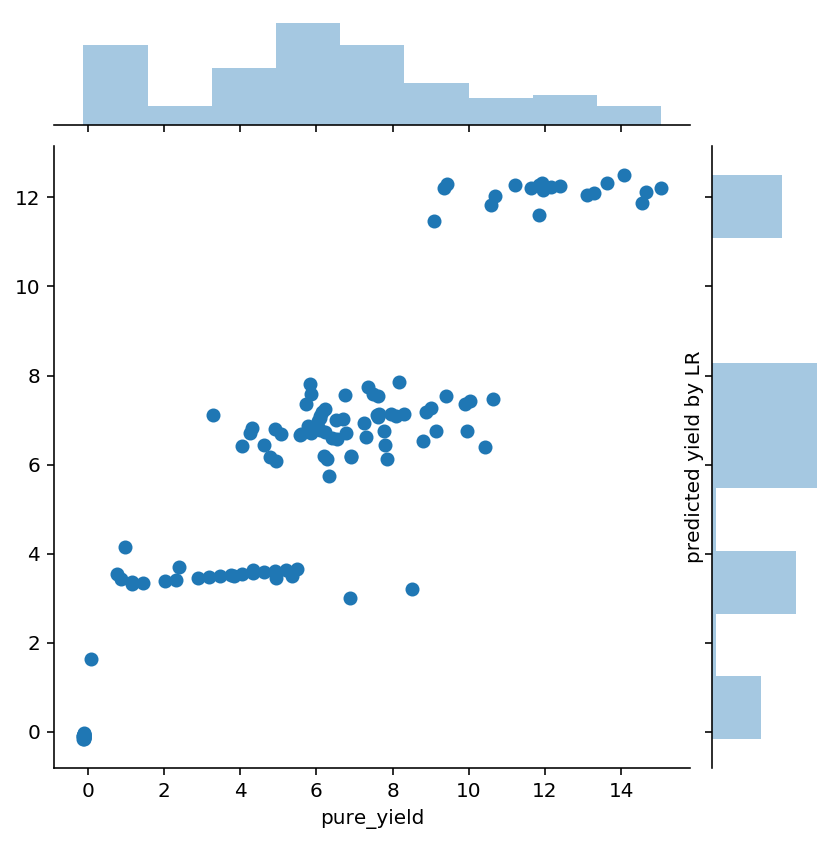

In [164]:
sns.jointplot(x=train.pure_yield, y=y_pred)
plt.gcf().gca().set_ylabel('predicted yield by LR')


Intresting. Basically three groups have been predicted. 

In the interest of time, sticking with LR. Just check on test set now

In [165]:
y_pred_test = lr_fit.predict(test.drop('pure_yield', axis=1))

In [166]:
sklearn.metrics.r2_score(y_true=test.pure_yield, y_pred=y_pred_test)

0.8345796153603872

Good enough. Very similar to training so that's a good sign ; we did not overfit on training. 

## Interpret

In [170]:
predictor_weights = pd.DataFrame({'predictor': train.drop('pure_yield', axis=1).columns, 'weight': lr_fit.coef_})

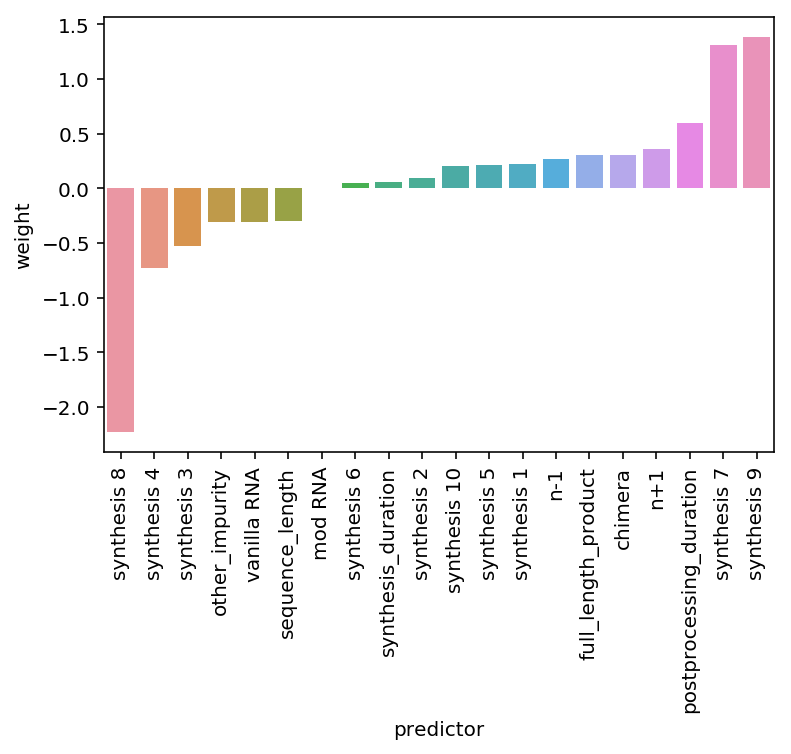

In [175]:
ax = sns.barplot(data=predictor_weights.sort_values('weight'), x='predictor', y='weight')
_ = plt.setp(ax.get_xticklabels(), rotation=90)


Hm. Okay, the type of synthesis had the largest effect on `pure_yield`, controlled for all the other features. Probably something went wrong in synthesis pools 8 and 9, basically (over-or-under-yield). 

In [ ]:
sns.pairplot(synth_data_numeric_std.sample(10))

If had more time: would see relationship between synthesis and other features, etc. 